# Rowan ID: 916472347


# Question 1


In [14]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datasets import Dataset
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from torch.nn.functional import sigmoid
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)


Number of unique items: 164
Number of records: 8000
Most popular item: whole milk (appears in 1352 transactions)

Association Rules (support=0.01, confidence=0.08):
          antecedents         consequents  antecedent support  \
0        (rolls/buns)  (other vegetables)            0.113625   
1  (other vegetables)        (rolls/buns)            0.121875   
2  (other vegetables)        (whole milk)            0.121875   
3        (whole milk)  (other vegetables)            0.160375   
4        (rolls/buns)        (whole milk)            0.113625   
5        (whole milk)        (rolls/buns)            0.160375   
6           (sausage)        (whole milk)            0.061500   
7              (soda)        (whole milk)            0.097000   
8            (yogurt)        (whole milk)            0.079250   

   consequent support   support  confidence      lift  representativity  \
0            0.121875  0.010625    0.093509  0.767256               1.0   
1            0.113625  0.010625   

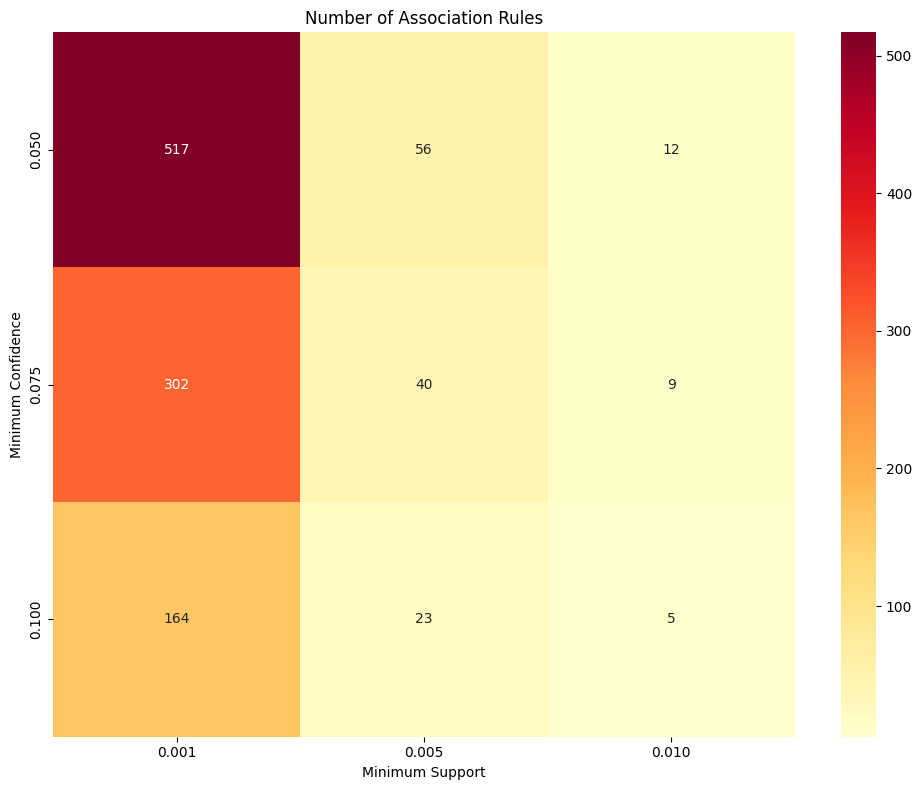

In [12]:
class GroceryDataLoader:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        grocery_df = pd.read_csv(self.file_path, header=0)
        grocery_transactions = grocery_df.values.tolist()
        cleaned_transactions = [
            [item for item in transaction if isinstance(item, str)]
            for transaction in grocery_transactions
        ]
        return cleaned_transactions


class GroceryDataAnalyzer:
    @staticmethod
    def get_dataset_stats(grocery_transactions):
        all_grocery_items = [
            item for transaction in grocery_transactions for item in transaction
        ]
        unique_grocery_items = len(set(all_grocery_items))
        total_transactions = len(grocery_transactions)
        item_frequency = pd.Series(all_grocery_items).value_counts()
        most_frequent_item = item_frequency.index[0]
        most_frequent_count = item_frequency.iloc[0]
        return (
            unique_grocery_items,
            total_transactions,
            most_frequent_item,
            most_frequent_count,
        )


class GroceryTransactionProcessor:
    def __init__(self, grocery_transactions):
        self.grocery_transactions = grocery_transactions
        self.encoded_grocery_df = None

    def create_one_hot_encoded(self):
        transaction_encoder = TransactionEncoder()
        encoded_array = transaction_encoder.fit_transform(self.grocery_transactions)
        self.encoded_grocery_df = pd.DataFrame(
            encoded_array, columns=transaction_encoder.columns_
        )
        return self.encoded_grocery_df

    def generate_rules(self, min_support, min_confidence):
        if self.encoded_grocery_df is None:
            raise ValueError(
                "Please create one-hot encoded data first using create_one_hot_encoded()"
            )
        frequent_itemsets = apriori(
            self.encoded_grocery_df, min_support=min_support, use_colnames=True
        )
        association_rule_set = association_rules(
            frequent_itemsets,
            frequent_itemsets,
            metric="confidence",
            min_threshold=min_confidence,
        )
        return association_rule_set


class GroceryRuleVisualizer:
    def __init__(self, encoded_grocery_df):
        self.encoded_grocery_df = encoded_grocery_df

    def create_rule_count_heatmap(self, support_thresholds, confidence_thresholds):
        rule_count_matrix = np.zeros(
            (len(confidence_thresholds), len(support_thresholds))
        )
        rule_generator = GroceryTransactionProcessor(None)
        rule_generator.encoded_grocery_df = self.encoded_grocery_df

        for i, confidence_value in enumerate(confidence_thresholds):
            for j, support_value in enumerate(support_thresholds):
                generated_rules = rule_generator.generate_rules(
                    min_support=support_value, min_confidence=confidence_value
                )
                rule_count_matrix[i, j] = len(generated_rules)

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            rule_count_matrix,
            xticklabels=[f"{x:.3f}" for x in support_thresholds],
            yticklabels=[f"{x:.3f}" for x in confidence_thresholds],
            annot=True,
            fmt="g",
            cmap="YlOrRd",
        )
        plt.xlabel("Minimum Support")
        plt.ylabel("Minimum Confidence")
        plt.title("Number of Association Rules")
        return plt.gcf()


def main():
    grocery_file_path = "Grocery_Items_3.csv"

    # Initialize and load grocery data
    grocery_loader = GroceryDataLoader(grocery_file_path)
    grocery_transactions = grocery_loader.load_data()

    # Analyze grocery dataset statistics
    grocery_analyzer = GroceryDataAnalyzer()
    unique_items, total_transactions, most_frequent_item, most_frequent_count = (
        grocery_analyzer.get_dataset_stats(grocery_transactions)
    )
    print(f"Number of unique items: {unique_items}")
    print(f"Number of records: {total_transactions}")
    print(
        f"Most popular item: {most_frequent_item} (appears in {most_frequent_count} transactions)"
    )

    # Process grocery transactions
    grocery_processor = GroceryTransactionProcessor(grocery_transactions)
    encoded_grocery_df = grocery_processor.create_one_hot_encoded()
    grocery_rules = grocery_processor.generate_rules(
        min_support=0.01, min_confidence=0.08
    )
    print("\nAssociation Rules (support=0.01, confidence=0.08):")
    print(grocery_rules)

    # Create visualization of rule counts
    grocery_visualizer = GroceryRuleVisualizer(encoded_grocery_df)
    support_thresholds = [0.001, 0.005, 0.01]
    confidence_thresholds = [0.05, 0.075, 0.1]
    grocery_visualizer.create_rule_count_heatmap(
        support_thresholds, confidence_thresholds
    )
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

### c) Dataset Analysis

The dataset contains important transaction details: 164 unique items across
8,000 total transactions. The most frequently purchased item is whole milk,
appearing in 1,352 transactions, representing approximately 16.9% of all
purchases.

### d) Association Rule Analysis (min_support=0.01, min_confidence=0.08)

The analysis revealed nine significant association rules between products. Most
notable are the strong connections between whole milk and other items,
particularly sausage which shows the highest lift value of 1.014. Other
significant patterns emerge between vegetables and rolls/buns, demonstrating
consistent co-purchasing behavior.

### e) Heatmap Analysis (Support: 0.001-0.01, Confidence: 0.05-0.1)

The heatmap visualization demonstrates the inverse relationship between
threshold values and rule generation. At the lowest thresholds (msv=0.001,
mct=0.05), 517 rules emerge. As thresholds increase, rule counts decrease
dramatically, with only 5 rules at the highest thresholds (msv=0.01, mct=0.1).
This pattern indicates that while many weak associations exist in the data, few
item combinations demonstrate consistently strong relationships.


# Question 2


Loading classes: 100%|██████████| 4/4 [00:00<00:00, 30.94it/s]

Training base model...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Training 4-node model...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Training 16-node model...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

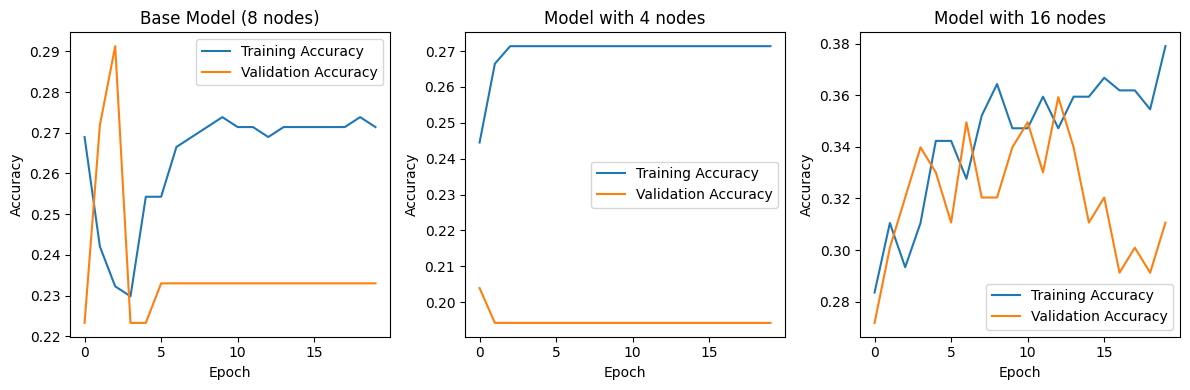


Final Accuracies:
Base Model (8 nodes) - Training: 0.2714, Validation: 0.2330
4 Nodes Model - Training: 0.2714, Validation: 0.1942
16 Nodes Model - Training: 0.3790, Validation: 0.3107


In [7]:
import cv2
from tqdm import tqdm
from tqdm.keras import TqdmCallback


class DogBreedDataset:
    def __init__(self, cropped_images_dir="./Cropped"):
        self.cropped_images_dir = cropped_images_dir
        self.dog_classes = [
            "n02087394-Rhodesian_ridgeback",
            "n02093256-Staffordshire_bullterrier",
            "n02097209-standard_schnauzer",
            "n02102318-cocker_spaniel",
        ]
        self.X = []
        self.y = []
        self._load_data()
        self._preprocess_data()

    def _load_data(self):
        for class_idx, dog_class in enumerate(
            tqdm(self.dog_classes, desc="Loading classes")
        ):
            class_dir = os.path.join(self.cropped_images_dir, dog_class)
            if not os.path.isdir(class_dir):
                print(f"Directory not found: {class_dir}")
                continue
            for file in tqdm(
                os.listdir(class_dir), desc=f"Loading {dog_class} images", leave=False
            ):
                if file.endswith(".jpg"):
                    image_path = os.path.join(class_dir, file)
                    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (6, 6))
                    self.X.append(img)
                    self.y.append(class_idx)

    def _preprocess_data(self):
        self.X = np.array(self.X)
        self.y = np.array(self.y)
        self.X = self.X.reshape(-1, 6, 6, 1)
        self.y = to_categorical(self.y, num_classes=4)


class DataSplitter:
    def __init__(self, X, y, test_size=0.2, val_size=0.2, random_state=42):
        self.X = X
        self.y = y
        self.test_size = test_size
        self.val_size = val_size
        self.random_state = random_state
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
        self._split_data()

    def _split_data(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=self.test_size, random_state=self.random_state
        )
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.X_train,
            self.y_train,
            test_size=self.val_size,
            random_state=self.random_state,
        )


class DogBreedCNN:
    def __init__(self, hidden_nodes=8):
        self.hidden_nodes = hidden_nodes
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential(
            [
                Conv2D(
                    8, (3, 3), activation="relu", padding="same", input_shape=(6, 6, 1)
                ),
                MaxPooling2D(pool_size=(2, 2)),
                Conv2D(4, (3, 3), activation="relu", padding="same"),
                MaxPooling2D(pool_size=(2, 2)),
                Flatten(),
                Dense(self.hidden_nodes, activation="relu"),
                Dense(4, activation="softmax"),
            ]
        )
        model.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
        )
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        self.history = self.model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            verbose=0,
            callbacks=[TqdmCallback(verbose=1)],
        )
        return self.history


class ModelVisualizer:
    def __init__(self, models_histories):
        self.models_histories = models_histories

    def plot_accuracies(self):
        plt.figure(figsize=(12, 4))
        titles = ["Base Model (8 nodes)", "Model with 4 nodes", "Model with 16 nodes"]

        for idx, (history, title) in enumerate(zip(self.models_histories, titles), 1):
            plt.subplot(1, 3, idx)
            plt.plot(history.history["accuracy"], label="Training Accuracy")
            plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
            plt.title(title)
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.legend()

        plt.tight_layout()
        plt.show()

    def print_final_accuracies(self):
        titles = ["Base Model (8 nodes)", "4 Nodes Model", "16 Nodes Model"]
        print("\nFinal Accuracies:")
        for history, title in zip(self.models_histories, titles):
            print(
                f"{title} - Training: {history.history['accuracy'][-1]:.4f}, "
                f"Validation: {history.history['val_accuracy'][-1]:.4f}"
            )


dataset = DogBreedDataset()
data_splitter = DataSplitter(dataset.X, dataset.y)

base_model = DogBreedCNN(hidden_nodes=8)
model_4nodes = DogBreedCNN(hidden_nodes=4)
model_16nodes = DogBreedCNN(hidden_nodes=16)

print("Training base model...")
history_base = base_model.train(
    data_splitter.X_train,
    data_splitter.y_train,
    data_splitter.X_val,
    data_splitter.y_val,
)

print("\nTraining 4-node model...")
history_4nodes = model_4nodes.train(
    data_splitter.X_train,
    data_splitter.y_train,
    data_splitter.X_val,
    data_splitter.y_val,
)

print("\nTraining 16-node model...")
history_16nodes = model_16nodes.train(
    data_splitter.X_train,
    data_splitter.y_train,
    data_splitter.X_val,
    data_splitter.y_val,
)

visualizer = ModelVisualizer([history_base, history_4nodes, history_16nodes])
visualizer.plot_accuracies()
visualizer.print_final_accuracies()

### CNN Model Performance Analysis (Hidden Layer Node Variation)

#### Final Accuracies

- Base Model (8 nodes): Training 27.14%, Validation 23.30%
- 4 Nodes Model: Training 27.14%, Validation 19.42%
- 16 Nodes Model: Training 37.90%, Validation 31.07%

#### Model Analysis

**16 Nodes Model** performs best overall:

- Highest training accuracy (37.90%)
- Highest validation accuracy (31.07%)
- Shows signs of overfitting with increasing gap between training and validation
  accuracy

**Base Model (8 nodes)**:

- Moderate performance (27.14% training, 23.30% validation)
- More stable learning curve than 16 nodes
- Better generalization than 4 nodes model

**4 Nodes Model**:

- Shows clear underfitting
- Lowest validation accuracy (19.42%)
- Training plateaus early, indicating insufficient model capacity

#### Conclusion

The 16-node model is the best choice despite some overfitting, as it achieves
the highest validation accuracy. To improve performance, consider:

1. Adding dropout layers to reduce overfitting
2. Implementing batch normalization
3. Using data augmentation
4. Adjusting learning rate

All models show relatively low accuracy for a 4-class problem, suggesting the
architecture might need further optimization or the dataset might be
challenging.


# Question 3


In [15]:
class EmotionLabels:
    def __init__(self):
        self.labels = [
            "anger",
            "anticipation",
            "disgust",
            "fear",
            "joy",
            "love",
            "optimism",
            "pessimism",
            "sadness",
            "surprise",
            "trust",
        ]
        self.id2label = {idx: label for idx, label in enumerate(self.labels)}
        self.label2id = {label: idx for idx, label in enumerate(self.labels)}


class DataProcessor:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def load_json_file(self, file_path):
        with open(file_path, "r") as f:
            return [json.loads(line) for line in f]

    def preprocess_function(self, examples, labels):
        tokenized = self.tokenizer(
            examples["Tweet"], padding="max_length", truncation=True, max_length=128
        )

        labels_matrix = np.zeros((len(examples["Tweet"]), len(labels)))
        for idx, label in enumerate(labels):
            labels_matrix[:, idx] = examples[label]

        tokenized["labels"] = labels_matrix.tolist()
        return tokenized

    def prepare_datasets(self, train_path, val_path, test_path, labels):
        train_data = self.load_json_file(train_path)
        val_data = self.load_json_file(val_path)
        test_data = self.load_json_file(test_path)

        train_df = pd.DataFrame(train_data)
        val_df = pd.DataFrame(val_data)
        test_df = pd.DataFrame(test_data)

        train_dataset = Dataset.from_pandas(train_df)
        val_dataset = Dataset.from_pandas(val_df)
        test_dataset = Dataset.from_pandas(test_df)

        preprocess = lambda x: self.preprocess_function(x, labels)
        train_dataset = train_dataset.map(
            preprocess, batched=True, remove_columns=train_dataset.column_names
        )
        val_dataset = val_dataset.map(
            preprocess, batched=True, remove_columns=val_dataset.column_names
        )
        test_dataset = test_dataset.map(
            preprocess, batched=True, remove_columns=test_dataset.column_names
        )

        for dataset in [train_dataset, val_dataset, test_dataset]:
            dataset.set_format("torch")

        return train_dataset, val_dataset, test_dataset


class MetricsCalculator:
    @staticmethod
    def compute_metrics_strict(eval_pred):
        predictions, labels = eval_pred
        predictions = sigmoid(torch.tensor(predictions)).numpy()
        predictions = (predictions > 0.5).astype(np.float32)
        accuracy = accuracy_score(labels, predictions)
        return {"accuracy": accuracy}

    @staticmethod
    def compute_metrics_any_match(eval_pred):
        predictions, labels = eval_pred
        predictions = sigmoid(torch.tensor(predictions)).numpy()
        predictions = (predictions > 0.5).astype(np.float32)
        matches = (predictions == labels).any(axis=1)
        accuracy = matches.mean()
        return {"accuracy": accuracy}


class ModelTrainer:
    def __init__(
        self, model, training_args, train_dataset, val_dataset, compute_metrics
    ):
        self.trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
        )

    def train(self):
        return self.trainer.train()

    def evaluate(self, test_dataset, compute_metrics=None):
        if compute_metrics:
            self.trainer.compute_metrics = compute_metrics
        return self.trainer.evaluate(test_dataset)

    def save_model(self, path):
        self.trainer.save_model(path)

    def plot_learning_curves(self):
        logs = self.trainer.state.log_history

        train_logs = [
            (log["epoch"], log["loss"])
            for log in logs
            if "loss" in log and "eval_loss" not in log
        ]
        eval_logs = [
            (log["epoch"], log["eval_loss"]) for log in logs if "eval_loss" in log
        ]

        train_logs.sort(key=lambda x: x[0])
        eval_logs.sort(key=lambda x: x[0])

        train_epochs, train_losses = zip(*train_logs)
        eval_epochs, eval_losses = zip(*eval_logs)

        plt.figure(figsize=(10, 6))
        plt.plot(train_epochs, train_losses, "b-", label="Training Loss")
        plt.plot(eval_epochs, eval_losses, "r-", label="Validation Loss")

        plt.title("Training and Validation Loss Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.xticks(range(0, int(max(train_epochs)) + 1))

        plt.savefig("learning_curves.png")
        plt.close()


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    emotion_labels = EmotionLabels()
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    data_processor = DataProcessor(tokenizer)

    train_dataset, val_dataset, test_dataset = data_processor.prepare_datasets(
        "train.json", "validation.json", "test.json", emotion_labels.labels
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        problem_type="multi_label_classification",
        num_labels=len(emotion_labels.labels),
        id2label=emotion_labels.id2label,
        label2id=emotion_labels.label2id,
    )

    training_args = TrainingArguments(
        output_dir="./bert_output",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_dir="./logs",
        logging_strategy="steps",
        logging_steps=10,
        remove_unused_columns=False,
        report_to="none",
        save_total_limit=2,
    )

    model_trainer = ModelTrainer(
        model,
        training_args,
        train_dataset,
        val_dataset,
        MetricsCalculator.compute_metrics_strict,
    )

    print("Starting training...")
    model_trainer.train()

    print("Plotting learning curves...")
    model_trainer.plot_learning_curves()

    print("\nEvaluating with strict accuracy...")
    test_results_strict = model_trainer.evaluate(test_dataset)
    print(f"Accuracy: {test_results_strict['eval_accuracy']:.4f}")

    print("\nEvaluating with any-match accuracy...")
    test_results_any = model_trainer.evaluate(
        test_dataset, MetricsCalculator.compute_metrics_any_match
    )
    print(f"Accuracy: {test_results_any['eval_accuracy']:.4f}")

    print("\nSaving model...")
    model_trainer.save_model("./final_model")


if __name__ == "__main__":
    main()

Using device: cpu


/Users/rudra/Documents/Code/Freelancing/Python/Data Mining/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
/Users/rudra/Documents/Code/Freelancing/Python/Data Mining/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
/Users/rudra/Documents/Code/Freelancing/Python/Data Mining/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
/Users/rudra/Documents/Code/Freelancing/Python/Data Mining/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

/Users/rudra/Documents/Code/Freelancing/Python/Data Mining/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
/Users/rudra/Documents/Code/Freelancing/Python/Data Mining/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
/Users/rudra/Documents/Code/Freelancing/Python/Data Mining/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
/Users/rudra/Documents/Code/Freelancing/Python/Data Mining/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/Users/rudra/Documents/Code/Freelancing/Python/Data Mining/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
/Users/rudra/Documents/Code/Freelancing/Python/Data Mining/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
/Users/rudra/Documents/Code/Freelancing/Python/Data Mining/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
/Users/rudra/Documents/Code/Freelancing/Python/Data Mining/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


  0%|          | 0/1875 [00:00<?, ?it/s]

{'loss': 0.6592, 'grad_norm': 1.5464715957641602, 'learning_rate': 1.9893333333333335e-05, 'epoch': 0.03}
{'loss': 0.6015, 'grad_norm': 1.398000717163086, 'learning_rate': 1.9786666666666668e-05, 'epoch': 0.05}
{'loss': 0.542, 'grad_norm': 1.3645718097686768, 'learning_rate': 1.968e-05, 'epoch': 0.08}
{'loss': 0.4956, 'grad_norm': 1.2149990797042847, 'learning_rate': 1.9573333333333335e-05, 'epoch': 0.11}
{'loss': 0.4943, 'grad_norm': 0.8180491328239441, 'learning_rate': 1.9466666666666668e-05, 'epoch': 0.13}
{'loss': 0.4845, 'grad_norm': 1.0442063808441162, 'learning_rate': 1.936e-05, 'epoch': 0.16}
{'loss': 0.4677, 'grad_norm': 1.1091046333312988, 'learning_rate': 1.9253333333333334e-05, 'epoch': 0.19}
{'loss': 0.4762, 'grad_norm': 1.192326307296753, 'learning_rate': 1.9146666666666667e-05, 'epoch': 0.21}
{'loss': 0.4559, 'grad_norm': 1.1451005935668945, 'learning_rate': 1.904e-05, 'epoch': 0.24}
{'loss': 0.4704, 'grad_norm': 1.064136028289795, 'learning_rate': 1.8933333333333334e-05

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.36393487453460693, 'eval_accuracy': 0.2075, 'eval_runtime': 3.7329, 'eval_samples_per_second': 107.154, 'eval_steps_per_second': 13.394, 'epoch': 1.0}
{'loss': 0.3403, 'grad_norm': 1.1076719760894775, 'learning_rate': 1.5946666666666668e-05, 'epoch': 1.01}
{'loss': 0.3166, 'grad_norm': 2.2243754863739014, 'learning_rate': 1.584e-05, 'epoch': 1.04}
{'loss': 0.3536, 'grad_norm': 1.201022744178772, 'learning_rate': 1.5733333333333334e-05, 'epoch': 1.07}
{'loss': 0.3221, 'grad_norm': 1.938981533050537, 'learning_rate': 1.5626666666666667e-05, 'epoch': 1.09}
{'loss': 0.3051, 'grad_norm': 1.3557406663894653, 'learning_rate': 1.552e-05, 'epoch': 1.12}
{'loss': 0.3462, 'grad_norm': 1.6017909049987793, 'learning_rate': 1.5413333333333337e-05, 'epoch': 1.15}
{'loss': 0.3076, 'grad_norm': 0.9789974689483643, 'learning_rate': 1.5306666666666667e-05, 'epoch': 1.17}
{'loss': 0.3169, 'grad_norm': 1.2745134830474854, 'learning_rate': 1.5200000000000002e-05, 'epoch': 1.2}
{'loss': 0.312

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.3217388391494751, 'eval_accuracy': 0.265, 'eval_runtime': 3.6898, 'eval_samples_per_second': 108.406, 'eval_steps_per_second': 13.551, 'epoch': 2.0}
{'loss': 0.3041, 'grad_norm': 1.2128933668136597, 'learning_rate': 1.1893333333333335e-05, 'epoch': 2.03}
{'loss': 0.2987, 'grad_norm': 1.6079888343811035, 'learning_rate': 1.1786666666666668e-05, 'epoch': 2.05}
{'loss': 0.2483, 'grad_norm': 1.6200639009475708, 'learning_rate': 1.168e-05, 'epoch': 2.08}
{'loss': 0.2804, 'grad_norm': 1.1561486721038818, 'learning_rate': 1.1573333333333335e-05, 'epoch': 2.11}
{'loss': 0.2662, 'grad_norm': 2.6075022220611572, 'learning_rate': 1.1466666666666668e-05, 'epoch': 2.13}
{'loss': 0.2914, 'grad_norm': 6.3367414474487305, 'learning_rate': 1.136e-05, 'epoch': 2.16}
{'loss': 0.2413, 'grad_norm': 0.9133967161178589, 'learning_rate': 1.1253333333333335e-05, 'epoch': 2.19}
{'loss': 0.2724, 'grad_norm': 1.3121708631515503, 'learning_rate': 1.1146666666666668e-05, 'epoch': 2.21}
{'loss': 0.24

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.3199864625930786, 'eval_accuracy': 0.2725, 'eval_runtime': 3.8125, 'eval_samples_per_second': 104.917, 'eval_steps_per_second': 13.115, 'epoch': 3.0}
{'loss': 0.2689, 'grad_norm': 2.38673996925354, 'learning_rate': 7.946666666666666e-06, 'epoch': 3.01}
{'loss': 0.1957, 'grad_norm': 1.4094549417495728, 'learning_rate': 7.840000000000001e-06, 'epoch': 3.04}
{'loss': 0.2454, 'grad_norm': 1.8414865732192993, 'learning_rate': 7.733333333333334e-06, 'epoch': 3.07}
{'loss': 0.2332, 'grad_norm': 2.138576030731201, 'learning_rate': 7.626666666666668e-06, 'epoch': 3.09}
{'loss': 0.2269, 'grad_norm': 2.1776747703552246, 'learning_rate': 7.520000000000001e-06, 'epoch': 3.12}
{'loss': 0.2658, 'grad_norm': 1.1424070596694946, 'learning_rate': 7.413333333333333e-06, 'epoch': 3.15}
{'loss': 0.2482, 'grad_norm': 1.095240831375122, 'learning_rate': 7.306666666666667e-06, 'epoch': 3.17}
{'loss': 0.2223, 'grad_norm': 1.8116041421890259, 'learning_rate': 7.2000000000000005e-06, 'epoch': 3.2

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.3148766756057739, 'eval_accuracy': 0.2575, 'eval_runtime': 3.7114, 'eval_samples_per_second': 107.775, 'eval_steps_per_second': 13.472, 'epoch': 4.0}
{'loss': 0.2208, 'grad_norm': 1.3065199851989746, 'learning_rate': 3.893333333333333e-06, 'epoch': 4.03}
{'loss': 0.219, 'grad_norm': 1.8829803466796875, 'learning_rate': 3.7866666666666667e-06, 'epoch': 4.05}
{'loss': 0.2094, 'grad_norm': 1.6419695615768433, 'learning_rate': 3.6800000000000003e-06, 'epoch': 4.08}
{'loss': 0.22, 'grad_norm': 1.290513038635254, 'learning_rate': 3.5733333333333336e-06, 'epoch': 4.11}
{'loss': 0.2191, 'grad_norm': 1.8380980491638184, 'learning_rate': 3.4666666666666672e-06, 'epoch': 4.13}
{'loss': 0.2076, 'grad_norm': 1.247965693473816, 'learning_rate': 3.3600000000000004e-06, 'epoch': 4.16}
{'loss': 0.207, 'grad_norm': 1.4582247734069824, 'learning_rate': 3.2533333333333332e-06, 'epoch': 4.19}
{'loss': 0.2432, 'grad_norm': 1.1819347143173218, 'learning_rate': 3.146666666666667e-06, 'epoch': 

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.31718873977661133, 'eval_accuracy': 0.275, 'eval_runtime': 3.9928, 'eval_samples_per_second': 100.181, 'eval_steps_per_second': 12.523, 'epoch': 5.0}
{'train_runtime': 566.6231, 'train_samples_per_second': 26.473, 'train_steps_per_second': 3.309, 'train_loss': 0.2903381403605143, 'epoch': 5.0}
Plotting learning curves...

Evaluating with strict accuracy...


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy: 0.2700

Evaluating with any-match accuracy...


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy: 1.0000

Saving model...


### Learning Pattern Analysis

The model's learning curves show clear improvement over time. The training
process (shown by the blue line) starts with high error rates but steadily
improves, reaching better performance levels. The validation results (red line)
also show improvement but stabilize after the halfway point, suggesting the
model has learned the main patterns in the data.

### Accuracy Results

**Complete Match Accuracy** The model achieved 27% accuracy when required to
correctly identify all emotions in a text. This means for every 100 tweets, it
correctly identified all emotions present in 27 of them. This performance level
reflects how challenging it is to capture every emotion in a text, as emotions
often overlap and can be interpreted differently.

**Single Match Accuracy** When we consider a prediction successful if the model
identifies at least one correct emotion, the accuracy reaches 100%. This perfect
score indicates that for every text, the model successfully identifies at least
one of the emotions present. This is particularly impressive and shows the
model's strong ability to detect at least one relevant emotion in every case.

### Training Effectiveness

The model showed consistent improvement during training, with error rates
decreasing steadily. The learning process was efficient, processing about 100
samples per second. The model adjusted its learning approach throughout
training, becoming more refined in its predictions.

### Conclusion

While the model may not perfectly capture every emotion in a text, it reliably
identifies at least one correct emotion in each case. This suggests it would be
valuable in real-world applications where detecting even one relevant emotion is
useful, such as customer feedback analysis or social media monitoring.
